In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from opxrd.wrapper import OpXRD
from opxrd.analysis import PlotAnalysis

import warnings
warnings.filterwarnings('ignore')

t1 = '/media/daniel/mirrors/xrd.aimat.science/local/final/CNRS'
t2 = '/media/daniel/mirrors/xrd.aimat.science/local/final/EMPA'
full_dirpath = '/media/daniel/mirrors/xrd.aimat.science/local/final'
is_full_run = True

if is_full_run:
    dbs = OpXRD.load_project_list(root_dirpath=full_dirpath)
else:
    d1 = OpXRD.load(dirpath=t1)
    d2 = OpXRD.load(dirpath=t2)
    dbs = [d1, d2]

analyser = PlotAnalysis(databases=dbs, output_dirpath='/tmp/opxrd_analysis')

 17% (60 of 338) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

- Loading databases from /media/daniel/mirrors/xrd.aimat.science/local/final
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/USC


100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000
100% (64 of 64) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
  1% (14 of 1052) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/USC
Successfully extracted 338 patterns from 338/338 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/IKFT
Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/IKFT
Successfully extracted 64 patterns from 64/64 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS


100% (1052 of 1052) |####################| Elapsed Time: 0:00:04 Time:  0:00:040000
100% (21 of 21) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 11% (57 of 499) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/CNRS
Successfully extracted 1052 patterns from 1052/1052 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST/HKUST-A
Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST/HKUST-A
Successfully extracted 21 patterns from 21/21 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST/HKUST-B


100% (499 of 499) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000
  0% (0 of 19796) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/HKUST/HKUST-B
Successfully extracted 499 patterns from 499/499 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/INT


100% (19796 of 19796) |##################| Elapsed Time: 0:00:26 Time:  0:00:260002
  0% (142 of 28765) |                    | Elapsed Time: 0:00:00 ETA:   0:00:20

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/INT
Successfully extracted 19796 patterns from 19796/19796 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-B


100% (28765 of 28765) |##################| Elapsed Time: 0:00:21 Time:  0:00:210001
  0% (119 of 39557) |                    | Elapsed Time: 0:00:00 ETA:   0:00:33

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-B
Successfully extracted 28765 patterns from 28765/28765 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-A


100% (39557 of 39557) |##################| Elapsed Time: 0:00:33 Time:  0:00:330002
 18% (256 of 1348) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:00

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-A
Successfully extracted 39557 patterns from 39557/39557 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-D


100% (1348 of 1348) |####################| Elapsed Time: 0:00:00 Time:  0:00:000000
 33% (113 of 342) |#######               | Elapsed Time: 0:00:00 ETA:   0:00:00

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-D
Successfully extracted 1348 patterns from 1348/1348 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-C


100% (342 of 342) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000
 19% (147 of 770) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:00

Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/LBNL/LBNL-C
Successfully extracted 342 patterns from 342/342 xrd files
Loading patterns from local dirpath /media/daniel/mirrors/xrd.aimat.science/local/final/EMPA


100% (770 of 770) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


Finished loading pattern database located at /media/daniel/mirrors/xrd.aimat.science/local/final/EMPA
Successfully extracted 770 patterns from 770/770 xrd files


---> Combined pattern plot for databaes ['a:USC', 'b:IKFT', 'c:CNRS', 'd:HKUST-A', 'e:HKUST-B', 'f:INT', 'g:LBNL-A', 'h:LBNL-B', 'i:LBNL-C', 'j:LBNL-D', 'k:EMPA'] | No. patterns = 50

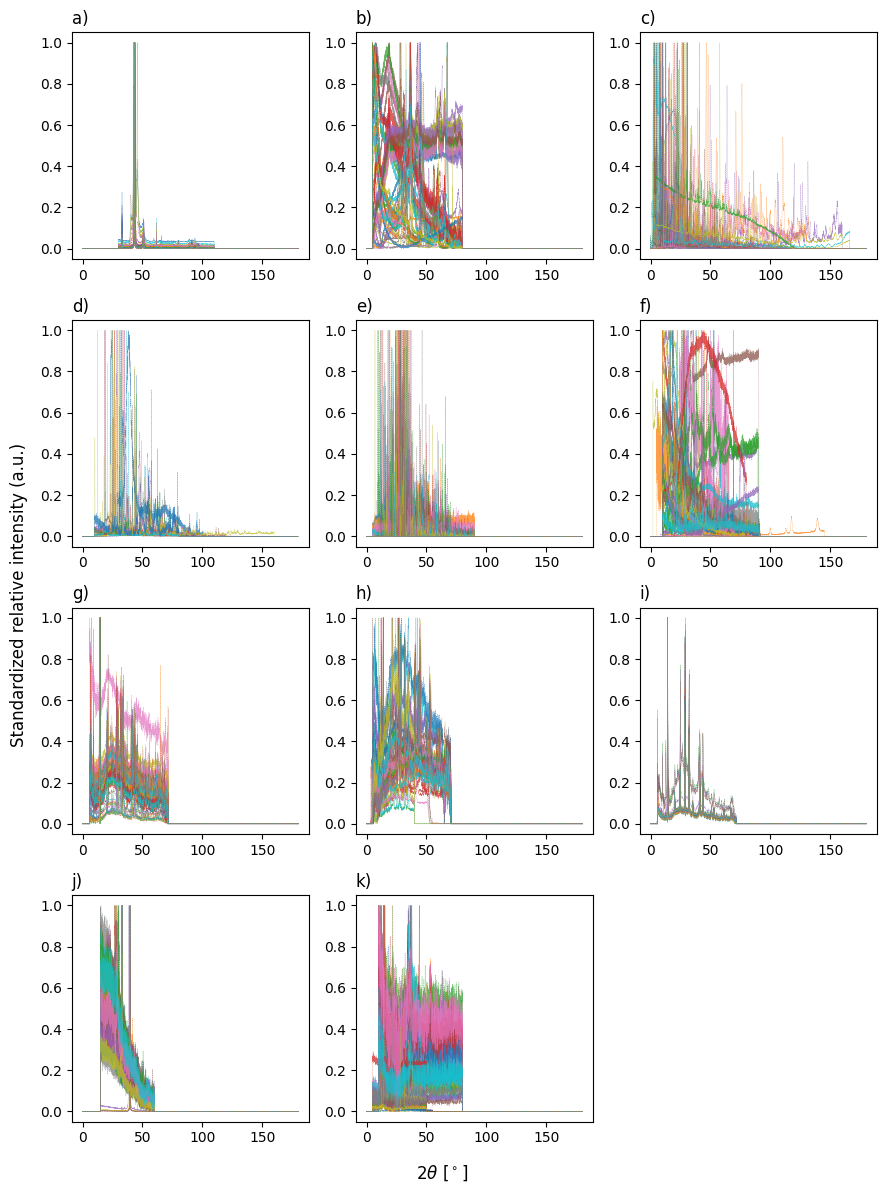

In [19]:
analyser.plot_in_single(limit_patterns=50)

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 338
[Debug]: Performing PCA for IKFT | No. patterns = 64
[Debug]: Performing PCA for CNRS | No. patterns = 1052
[Debug]: Performing PCA for HKUST-A | No. patterns = 21
[Debug]: Performing PCA for HKUST-B | No. patterns = 499
[Debug]: Performing PCA for INT | No. patterns = 19796
[Debug]: Performing PCA for LBNL-A | No. patterns = 28765
[Debug]: Performing PCA for LBNL-B | No. patterns = 39557
[Debug]: Performing PCA for LBNL-C | No. patterns = 1348
[Debug]: Performing PCA for LBNL-D | No. patterns = 342


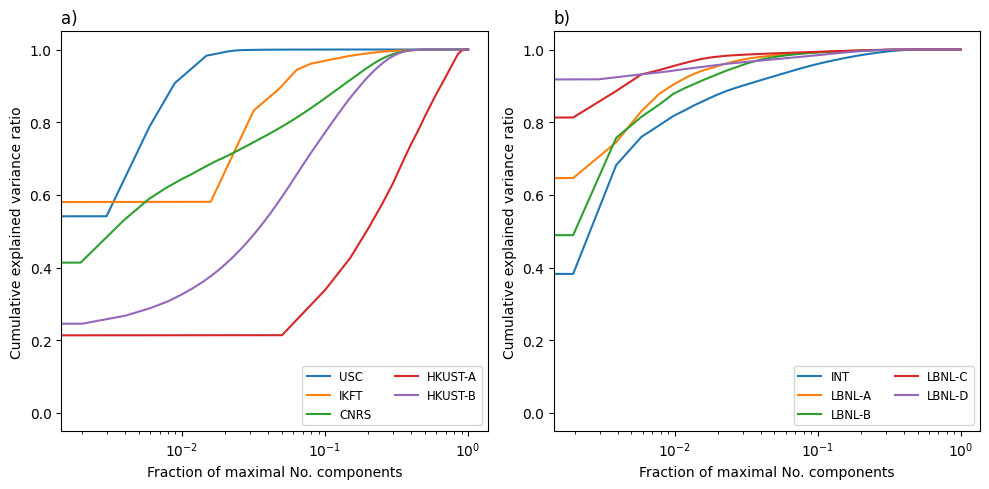

---> Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 338
[Debug]: Performing PCA for IKFT | No. patterns = 64
[Debug]: Performing PCA for CNRS | No. patterns = 1052
[Debug]: Performing PCA for HKUST-A | No. patterns = 21
[Debug]: Performing PCA for HKUST-B | No. patterns = 499
[Debug]: Performing PCA for INT | No. patterns = 19796
[Debug]: Performing PCA for LBNL-A | No. patterns = 28765
[Debug]: Performing PCA for LBNL-B | No. patterns = 39557
[Debug]: Performing PCA for LBNL-C | No. patterns = 1348
[Debug]: Performing PCA for LBNL-D | No. patterns = 342


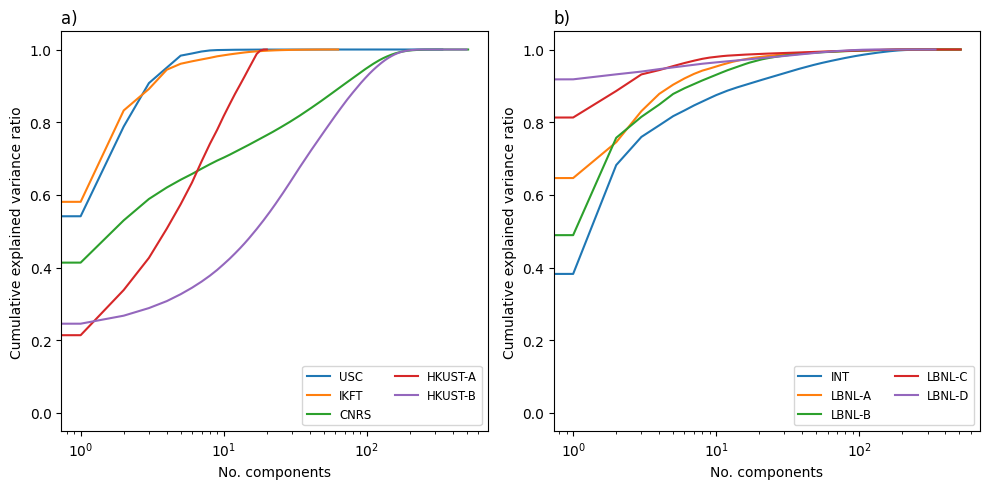

In [20]:
analyser.plot_effective_components()
analyser.plot_effective_components(use_fractions=False)

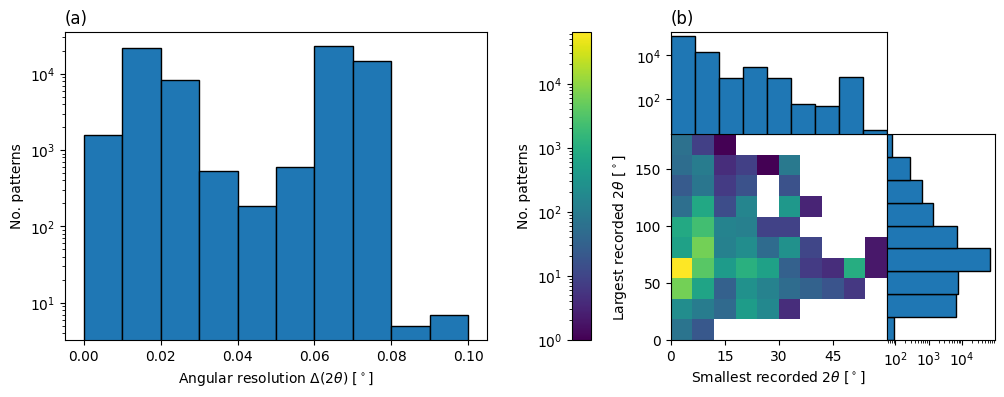

---> Histograms detailing properties of all diffraction patterns in the opXRD database: a) distribution of angular resolutions; b) distribution of smallest and largest recorded 2θ values.

In [21]:
analyser.xrd_histogram()
analyser.print_text(f'---> Histograms detailing properties of all diffraction patterns in the opXRD database: a) distribution of angular resolutions; b) distribution of smallest and largest recorded 2θ values.')

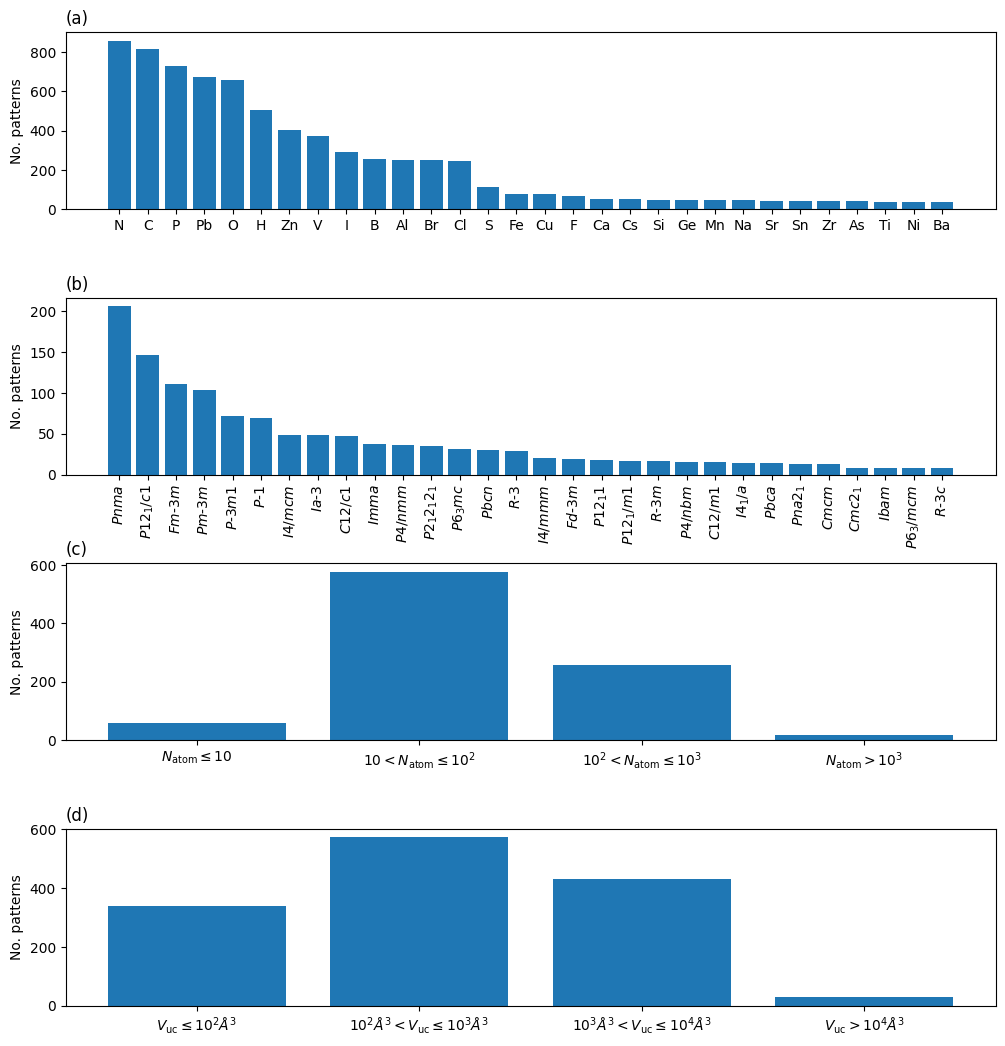

---> Histograms detailing properties of the structures underlying labeled diffraction patterns in the opXRD database: a) distribution of structures containing specified elements;b) distribution of structures containing spacegroups; c) distribution of No. atoms N_{\text{atom}} contained in unit cell; d) distribution of unit cell volume V_{\text{uc}}

In [32]:
analyser.structure_histogram()
analyser.print_text(f'---> Histograms detailing properties of the structures underlying labeled diffraction patterns in the opXRD database: '
                    f'a) distribution of structures containing specified elements;'
                    r'b) distribution of structures containing spacegroups; '
                    r'c) distribution of No. atoms N_{\text{atom}} contained in unit cell; '
                    r'd) distribution of unit cell volume V_{\text{uc}}')

In [34]:
analyser.show_label_fractions()

---> Overview of label fractions per contribution

+-------------+----------------+---------------+-------+-----------+---------+
|             |   No. patterns |   composition |   spg |   lattice |   basis |
|-------------+----------------+---------------+-------+-----------+---------|
| USC         |            338 |            10 |    10 |        90 |       0 |
| IKFT        |             64 |             0 |     0 |         0 |       0 |
| CNRS        |           1052 |            85 |    85 |       100 |      85 |
| HKUST-A     |             21 |           100 |   100 |       100 |     100 |
| HKUST-B     |            499 |             0 |     0 |         0 |       0 |
| INT         |          19796 |             0 |     0 |         0 |       0 |
| LBNL-A      |          28765 |             0 |     0 |         0 |       0 |
| LBNL-B      |          39557 |             0 |     0 |         0 |       0 |
| LBNL-C      |           1348 |             0 |     0 |         0 |       0 |
| LBNL-D      |            342 |             0 |    